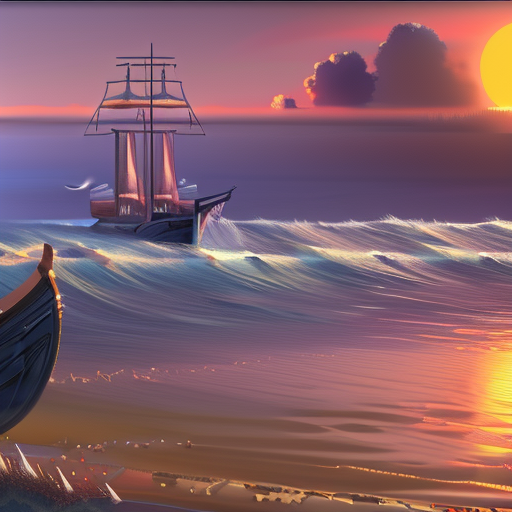

In [4]:
latents = init_latents.detach().clone()

@torch.no_grad()
def denoise(
	pipe, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5
):
	timesteps, num_inference_steps = pipe.retrieve_timesteps(num_inference_steps)

	for t in timesteps:
		latent_model_input = torch.cat([latents] * 2)

		# Predict the noise residual for the current timestep
		noise_residual = pipe.unet(
			latent_model_input, t, encoder_hidden_states=prompt_embeds
		)
		uncond_residual, text_cond_residual = noise_residual.chunk(2)
		guided_noise_residual = uncond_residual + guidance_scale * (
			text_cond_residual - uncond_residual
		)

		# Update latents by reversing the diffusion process for the current timestep
		latents = pipe.scheduler.step(guided_noise_residual, t, latents)[0]

	return latents

latents = denoise(pipe, latents, prompt_embeds, num_inference_steps, guidance_scale)
image = pipe.vae_decode(latents)
image